In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
%matplotlib inline
pd.set_option('display.max_rows', 1000)
sns.set()

### Bid Ask Spread Data of GBP/USD

In [2]:
df = pd.read_excel("/Users/krutarth/Downloads/Bid_Ask_Spread.xlsx")

In [3]:
df['Bid_Ask_Spread'] = df['Ask'] - df['Bid'] 
df.head()

,Unnamed: 0,Bid,Ask,Bid_Ask_Spread
0,2018-01-07 22:02:04,1.35554,1.35618,0.00064
1,2018-01-07 22:02:05,1.35554,1.35619,0.00065
2,2018-01-07 22:02:06,1.35554,1.35619,0.00065
3,2018-01-07 22:02:07,1.35546,1.35619,0.00073
4,2018-01-07 22:02:08,1.35546,1.35619,0.00073


In [4]:
df = df.rename(columns={"Unnamed: 0": "TimeStamp"})

In [5]:
df.head()

,TimeStamp,Bid,Ask,Bid_Ask_Spread
0,2018-01-07 22:02:04,1.35554,1.35618,0.00064
1,2018-01-07 22:02:05,1.35554,1.35619,0.00065
2,2018-01-07 22:02:06,1.35554,1.35619,0.00065
3,2018-01-07 22:02:07,1.35546,1.35619,0.00073
4,2018-01-07 22:02:08,1.35546,1.35619,0.00073


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431814 entries, 0 to 431813
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   TimeStamp       431814 non-null  datetime64[ns]
 1   Bid             431814 non-null  float64       
 2   Ask             431814 non-null  float64       
 3   Bid_Ask_Spread  431814 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 13.2 MB


### Trade Execution Data

In [7]:
execution = pd.read_csv('/Users/krutarth/Downloads/TradeExecution.csv', parse_dates=['Time'])
execution = execution.rename(columns={"Time": "TimeStamp"})
execution.head()

,Side,TimeStamp
0,B,2018-01-07 22:04:12
1,S,2018-01-07 22:04:13
2,B,2018-01-07 22:04:14
3,S,2018-01-07 22:04:15
4,B,2018-01-07 22:04:16


### Final Dataframe of merged traded order book data.

In [8]:
execution = pd.merge(df, execution, on="TimeStamp")
execution = execution.copy()

In [9]:
execution['Mid'] = 0.5 * (execution['Bid'] + execution['Ask'])

In [10]:
execution.head()

,TimeStamp,Bid,Ask,Bid_Ask_Spread,Side,Mid
0,2018-01-07 22:04:12,1.35558,1.35615,0.00057,B,1.355865
1,2018-01-07 22:04:13,1.35558,1.35615,0.00057,S,1.355865
2,2018-01-07 22:04:14,1.35558,1.35615,0.00057,B,1.355865
3,2018-01-07 22:04:15,1.35558,1.35615,0.00057,S,1.355865
4,2018-01-07 22:04:16,1.35558,1.35615,0.00057,B,1.355865


In [11]:
execution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 89
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TimeStamp       90 non-null     datetime64[ns]
 1   Bid             90 non-null     float64       
 2   Ask             90 non-null     float64       
 3   Bid_Ask_Spread  90 non-null     float64       
 4   Side            90 non-null     object        
 5   Mid             90 non-null     float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 4.9+ KB


## First Method: Immediate Execution at Market Price

* To execute each order, we will act as a market taker and immediately execute trades at the current bid/offer price, which incurs a cost equal to half of the bid/offer spread. Therefore, every time we trade, we will lose an amount equivalent to half of the spread.

In [12]:
execution['PnL'] = -0.5 * execution['Bid_Ask_Spread']
execution.head()

,TimeStamp,Bid,Ask,Bid_Ask_Spread,Side,Mid,PnL
0,2018-01-07 22:04:12,1.35558,1.35615,0.00057,B,1.355865,-0.000285
1,2018-01-07 22:04:13,1.35558,1.35615,0.00057,S,1.355865,-0.000285
2,2018-01-07 22:04:14,1.35558,1.35615,0.00057,B,1.355865,-0.000285
3,2018-01-07 22:04:15,1.35558,1.35615,0.00057,S,1.355865,-0.000285
4,2018-01-07 22:04:16,1.35558,1.35615,0.00057,B,1.355865,-0.000285


## Second Method: Market Making with Strategic Implementation

* For each order, we will place it within the Bid/Offer spread and wait for an opportunity for execution. During this time, the order may be executed at a more favorable price, but if not, we will still incur the cost of half of the spread when the order is eventually executed.

* We can set a maximum stop loss (SL) value to limit potential losses if the market moves against us. If the SL is triggered, we will then aggressively execute the order. We can choose a value for the SL, such as -3 basis points (-0.03%).

* Similarly, we can set a maximum time left to execution (TTE) value to limit the amount of time we are willing to wait for an opportunistic execution. If the TTE is reached, we will also aggressively execute the order. We can choose a value for the TTE, such as 15 seconds.

In [13]:
SL = -0.0003
TTE = timedelta(seconds=15).total_seconds()
TTE

15.0

#### We will implement the second method with two seperate strategies.  

### Strategic Market Price

* We are willing to transact at a price that is favorable to the market maker or liquidity provider, rather than waiting for a better price. This can result in a quicker execution, but it also means that we are paying the spread, which is the difference between the bid and offer price.

In [14]:
def SMM_Picking(SL,TTE):
    #Initialize
    SMM_Picking_Pnl = []       # execute pnl list
    SMM_Picking_TE = []        # Time to Execution
    SMM_Picking_Execution = [] # Execution type - TTE,SL,or Success
    for i in range(len(execution)):
        df2 = df[df['TimeStamp'] > execution.loc[i,'TimeStamp']]
        df2 = df2.reset_index()
        Mid = execution.loc[i,'Mid']
        if execution.loc[i,'Side'] == 'B':
            side_price = execution.loc[i,'Bid']
            stop_loss_line = execution.loc[i,'Ask'] - SL
            # wait in mkt
            wait = 0
            while side_price < df2.loc[wait,'Ask'] and df2.loc[wait, 'Ask'] < stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if side_price >= df2.loc[wait,'Ask']:
                execute_price = side_price
            else:
                execute_price = df2.loc[wait, 'Ask'] #aggress the mkt
            # compute pnl
            SMM_Picking_Pnl.append(Mid - execute_price)
            SMM_Picking_TE.append(wait + 1)
            if execute_price >= stop_loss_line :
                SMM_Picking_Execution.append('SL')
            elif wait == TTE - 1:
                SMM_Picking_Execution.append('TTE')
            else:
                SMM_Picking_Execution.append('Success')
                
        else : #Side =='S'
            side_price = execution.loc[i, 'Ask']
            stop_loss_line = execution.loc[i,'Bid'] + SL
            wait = 0
            while side_price > df2.loc[wait, 'Bid'] and df2.loc[wait, 'Bid'] > stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if side_price <= df2.loc[wait,'Bid']:
                execute_price = side_price
            else:
                execute_price = df2.loc[wait, 'Bid'] #aggress the mkt
            # pnl
            SMM_Picking_Pnl.append(execute_price - Mid)
            SMM_Picking_TE.append(wait + 1)
            if execute_price <= stop_loss_line :
                SMM_Picking_Execution.append('SL')
            elif wait == TTE - 1:
                SMM_Picking_Execution.append('TTE')
            else :
                SMM_Picking_Execution.append('Success')
    # Edit in executionSet directly            
    execution['SMM_Picking_Pnl'] = SMM_Picking_Pnl
    execution['SMM_Picking_TE'] = SMM_Picking_TE
    execution['SMM_Picking_Execution'] = SMM_Picking_Execution
    return np.median(SMM_Picking_Pnl)

In [15]:
SMM_Picking(SL,TTE)
execution

,TimeStamp,Bid,Ask,Bid_Ask_Spread,Side,Mid,PnL,SMM_Picking_Pnl,SMM_Picking_TE,SMM_Picking_Execution
0,2018-01-07 22:04:12,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE
1,2018-01-07 22:04:13,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE
2,2018-01-07 22:04:14,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE
3,2018-01-07 22:04:15,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE
4,2018-01-07 22:04:16,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE
5,2018-01-07 22:04:17,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE
6,2018-01-07 22:04:18,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE
7,2018-01-07 22:04:19,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE
8,2018-01-07 22:04:20,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE
9,2018-01-07 22:04:21,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE


### Strategic Market Price Mid

* Placing an order at the mid price means that you are placing an order to buy or sell a security at a price that is in between the current bid and ask prices. By placing an order at the mid price, you are essentially waiting for the market to move towards your desired price level before executing the trade.

* If the market moves towards your order, it is likely that you will buy or sell the security at the mid price. This strategy is often used by traders who want to minimize their transaction costs and are willing to wait for the market to move in their favor.

In [16]:
def SMM_Mid(SL,TTE):
    #Initialize
    SMM_Mid_Pnl = []       # execute pnl list
    SMM_Mid_TE = []        # Time to Execution
    SMM_Mid_Execution = [] # Execution type - TTE,SL,or Success
    for i in range(len(execution)):
        df2 = df[df['TimeStamp'] > execution.loc[i,'TimeStamp']]
        df2 = df2.reset_index()
        Mid = execution.loc[i,'Mid']
        if execution.loc[i,'Side'] == 'B':
            stop_loss_line = execution.loc[i,'Ask'] - SL
            # wait in mkt
            wait = 0
            while Mid < df2.loc[wait,'Ask'] and df2.loc[wait, 'Ask'] < stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if Mid >= df2.loc[wait,'Ask']:
                execute_price = Mid
            else:
                execute_price = df2.loc[wait, 'Ask'] #aggress the mkt
            # compute pnl
            SMM_Mid_Pnl.append(Mid - execute_price)
            SMM_Mid_TE.append(wait + 1)
            if execute_price >= stop_loss_line :
                SMM_Mid_Execution.append('SL')
            elif wait == TTE - 1:
                SMM_Mid_Execution.append('TTE')
            else:
                SMM_Mid_Execution.append('Success')
                
        else : #Side =='S'
            stop_loss_line = execution.loc[i, 'Bid'] + SL
            wait = 0
            while Mid > df2.loc[wait, 'Bid'] and df2.loc[wait, 'Bid'] > stop_loss_line and wait < TTE - 1:
                wait = wait + 1
            if Mid <= df2.loc[wait,'Bid']:
                execute_price = Mid
            else:
                execute_price = df2.loc[wait, 'Bid'] #aggress the mkt
            # pnl
            SMM_Mid_Pnl.append(execute_price - Mid)
            SMM_Mid_TE.append(wait + 1)
            if execute_price <= stop_loss_line :
                SMM_Mid_Execution.append('SL')
            elif wait == TTE - 1:
                SMM_Mid_Execution.append('TTE')
            else :
                SMM_Mid_Execution.append('Success')
    # Edit in executionSet directly            
    execution['SMM_Mid_Pnl'] = SMM_Mid_Pnl
    execution['SMM_Mid_TE'] = SMM_Mid_TE
    execution['SMM_Mid_Execution'] = SMM_Mid_Execution
    return np.median(SMM_Mid_Pnl)

In [17]:
SMM_Mid(SL,TTE)
execution

,TimeStamp,Bid,Ask,Bid_Ask_Spread,Side,Mid,PnL,SMM_Picking_Pnl,SMM_Picking_TE,SMM_Picking_Execution,SMM_Mid_Pnl,SMM_Mid_TE,SMM_Mid_Execution
0,2018-01-07 22:04:12,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
1,2018-01-07 22:04:13,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
2,2018-01-07 22:04:14,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
3,2018-01-07 22:04:15,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
4,2018-01-07 22:04:16,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
5,2018-01-07 22:04:17,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
6,2018-01-07 22:04:18,1.35558,1.35615,0.00057,B,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
7,2018-01-07 22:04:19,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
8,2018-01-07 22:04:20,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE
9,2018-01-07 22:04:21,1.35558,1.35615,0.00057,S,1.355865,-0.000285,-0.000285,15,TTE,-0.000285,15,TTE


### Let's do the Profit and Loss Analysis

In [18]:
# Calculating the statistics of each strategies
# Method 1: Immediate Execution at Market Price
immediate_min = execution['PnL'].min()
immediate_max = execution['PnL'].max()
immediate_std = execution['PnL'].std()
immediate_mean = execution['PnL'].mean()
immediate_median = execution['PnL'].median()

# Method 2: Strategic Market Price
SMM_Picking_min = execution['SMM_Picking_Pnl'].min()
SMM_Picking_max = execution['SMM_Picking_Pnl'].max()
SMM_Picking_std = execution['SMM_Picking_Pnl'].std()
SMM_Picking_mean = execution['SMM_Picking_Pnl'].mean()
SMM_Picking_median = execution['SMM_Picking_Pnl'].median()

# Method 3: Strategic Market Price Mid
SMM_Mid_min = execution['SMM_Mid_Pnl'].min()
SMM_Mid_max = execution['SMM_Mid_Pnl'].max()
SMM_Mid_std = execution['SMM_Mid_Pnl'].std()
SMM_Mid_mean = execution['SMM_Mid_Pnl'].mean()
SMM_Mid_median = execution['SMM_Mid_Pnl'].median()

#### Make a new data frame and store the values for visualizing the profits and loss.

In [19]:
profit_loss = {'Immediate Execution' : [immediate_min, immediate_max, immediate_std, immediate_mean, immediate_median], 'SMM_Picking' : [SMM_Picking_min, SMM_Picking_max, SMM_Picking_std, SMM_Picking_mean, SMM_Picking_median], 'SMM_Mid': [SMM_Mid_min, SMM_Mid_max, SMM_Mid_std, SMM_Mid_mean, SMM_Mid_median]}
profit_loss = pd.DataFrame(data = profit_loss, index = ['PnL_min', 'PnL_max', 'PnL_std', 'PnL_mean', 'PnL_median'])
profit_loss = (profit_loss*10000).round(3) # for converting to basis points
profit_loss

,Immediate Execution,SMM_Picking,SMM_Mid
PnL_min,-2.850,-4.300,-4.300
PnL_max,-0.000,0.500,0.000
PnL_std,1.023,1.520,1.437
PnL_mean,-0.667,-1.196,-1.243
PnL_median,-0.200,-0.925,-0.125


#### Here from this analysis we can conclude that,
* Minimum Profit and Loss :  Immediate Execution > Strategic Market Price = Strategic Market Price Mid
* Maximum Profit and Loss :  Strategic Market Price > Strategic Market Price Mid = Immediate Execution
* Standard deviation of Profit and Loss :  Strategic Market Price > Strategic Market Price Mid > Immediate Execution
* Mean of Profit and Loss :  Immediate Execution > Strategic Market Price > Strategic Market Price Mid
* Median Profit and Loss :  Strategic Market Price Mid > Immediate Execution = Strategic Market Price

#### Keynotes from above results
* Immediate execution strategy has the highest mean for profit and loss, so that concludes that Market Making with Strategic Implementation is not always a good idea for saving our money.
* Immediate execution strategy has the highest minimum profit and loss because there is no stopping time as it executes at the market price and it does not trigger the stop loss and there is no time left to execution.
* Strategic Market Price has the highest maximum profit and loss. This is the only strategy that is giving us positive profit and loss at execution.
* Strategic Market Price also has the highest standard deviation, that means that the risk increases the more we try to save our costs while executing the orders.

Text(0.5, 1.0, 'Profit and Loss Analysis (Basis Points)')

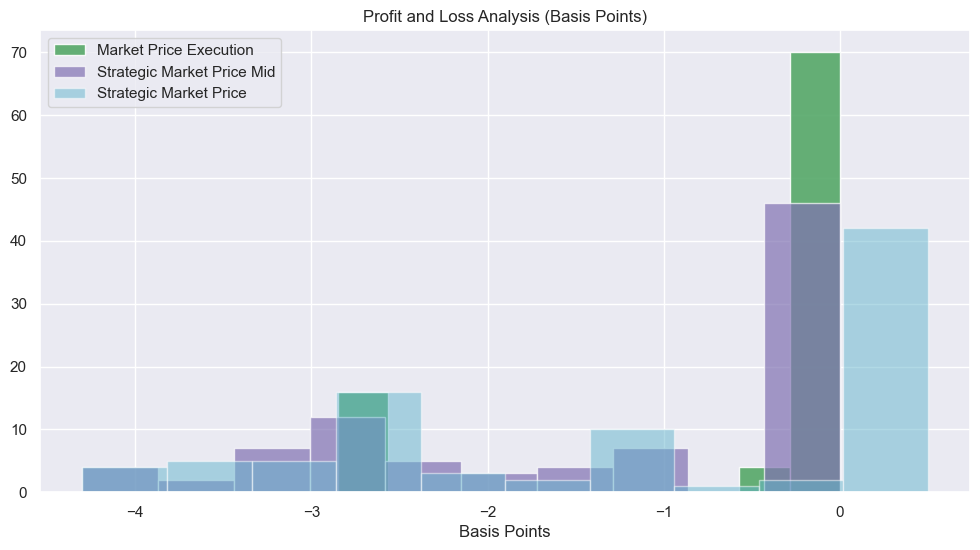

In [20]:
fig1 = plt.figure(figsize=[12,6])
ax = fig1.add_subplot(111)
(execution['PnL']*10000).hist(alpha=0.9, color='g', ax=ax, label='Market Price Execution')
(execution['SMM_Mid_Pnl']*10000).hist(alpha=0.7, color='m', ax=ax, label='Strategic Market Price Mid')
(execution['SMM_Picking_Pnl']*10000).hist(alpha=0.5, color='c', ax=ax, label='Strategic Market Price')
ax.legend()
plt.xlabel("Basis Points")
plt.title('Profit and Loss Analysis (Basis Points)')

### Analysis of Time to Execution (TTE) / Duration 

We don't have to calculate the duration or time left for execution for the immediately execution strategy because it executes at market price.

In [21]:
mean_SMM_Picking_TTE = execution['SMM_Picking_TE'].mean()
median_SMM_Picking_TTE = execution['SMM_Picking_TE'].median()
mean_SMM_Mid_TTE = execution['SMM_Mid_TE'].mean()
median_SMM_Mid_TTE = execution['SMM_Mid_TE'].median()

In [22]:
duration = {'SMM_Picking' : [mean_SMM_Picking_TTE, median_SMM_Picking_TTE], 'SMM_Mid' : [mean_SMM_Mid_TTE, median_SMM_Mid_TTE]} 
df_duration = pd.DataFrame(data = duration, index = ['Mean of the Duration', 'Median of the Duration'])
df_duration

,SMM_Picking,SMM_Mid
Mean of the Duration,8.966667,8.322222
Median of the Duration,9.000000,7.000000


* Here we can see that the time of execution is higher for SMM strategy than SMM Mid strategy. 
* This is achieved because the SMM strategy is implemented in our favor, thus it requires more time to execute and we have to wait for that price to reach to our order price.

### Analysis of stop losses and time limits

In [23]:
# Counts of strategy got succesfully triggered, stop losses, and time limits
[success_SMM_Picking, SMM_Picking_TTE, SMM_Picking_SL] = list(execution['SMM_Picking_Execution'].value_counts())
[success_SMM_Mid, SMM_Mid_TTE, SMM_Mid_SL] = list(execution['SMM_Mid_Execution'].value_counts())

trigger = {'SMM_Picking' : [SMM_Picking_TTE, SMM_Picking_SL, success_SMM_Picking], 'SMM_Mid' : [SMM_Mid_TTE, SMM_Mid_SL, success_SMM_Mid]}
trigger_df = pd.DataFrame(data = trigger, index = ['Count of Time to execution', 'Count of Stop Losses', 'Count of Successes']).T
trigger_df

,Count of Time to execution,Count of Stop Losses,Count of Successes
SMM_Picking,39,10,41
SMM_Mid,35,10,45


* By analyzing the above dataframe we can say that both the SMM strategies are likely to get triggered by time limit.
* The bid ask spread updates every seconds, so it is less likely to hit stop losses.
* SMM_Picking strategy has more number of stop losses than SMM_Mid because of the conditions that we added.

### Visualizing the impact of different strategies on stop losses

In [24]:
range_stoploss = np.arange(0, -0.0006, -0.00001)
# Creating the empty lists and appending the TTE, and SL values in this empty lists with for loop.
SMM_Picking_median_pnl = []
SMM_Mid_median_pnl  = []

for i in range_stoploss:
    SMM1, SMM2 = SMM_Picking(i,TTE), SMM_Mid(i,TTE)
    SMM_Picking_median_pnl.append(SMM1)
    SMM_Mid_median_pnl.append(SMM2)

Text(0.5, 1.0, 'Stop Losses execution influence on profit and losses of both strategies')

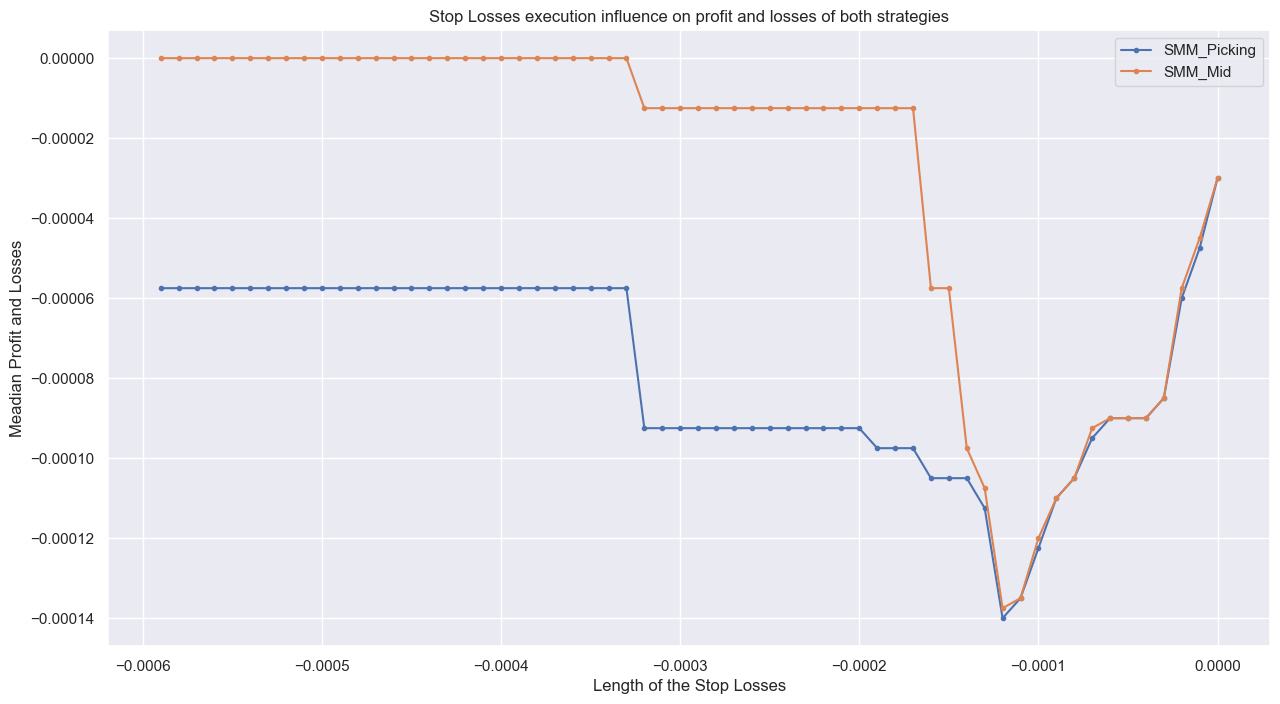

In [25]:
dictionary_stoploss = {'SMM_Picking':SMM_Picking_median_pnl, 'SMM_Mid':SMM_Mid_median_pnl}
stoploss_df = pd.DataFrame(data = dictionary_stoploss, index = range_stoploss)
stoploss_pnl = plt.figure(figsize=(15, 8))
ax = stoploss_pnl.add_subplot(111)
stoploss_df.plot(y=['SMM_Picking', 'SMM_Mid'], use_index=True, style='.-',ax=ax)
ax.set_xlabel('Length of the Stop Losses')
ax.set_ylabel('Meadian Profit and Losses') 
plt.title('Stop Losses execution influence on profit and losses of both strategies')

* Time left for execution = 15, SL Range = -6 Basis points to 0.
* As the stop losses gets closer to 0, the SMM_Picking strategy is getting higher Profit and loss compared to SMM_Mid strategy.
* As the stop losses gets lower than 0, the SMM_Mid strategy is getting higher Profit and loss.

### Visualizing the impact of different strategies on time left to execution.

In [26]:
range_tte = np.arange(5, 50, 1)
# Creating the empty lists and appending the TTE, and SL values in this empty lists with for loop.
SMM_Picking_median_pnl_tte = []
SMM_Mid_median_pnl_tte = []

for j in range_tte:
    SMM1, SMM2 = SMM_Picking(SL,j), SMM_Mid(SL,j)
    SMM_Picking_median_pnl_tte.append(SMM1)
    SMM_Mid_median_pnl_tte.append(SMM2)

Text(0.5, 1.0, 'Time limit execution influence on profit and losses of both strategies')

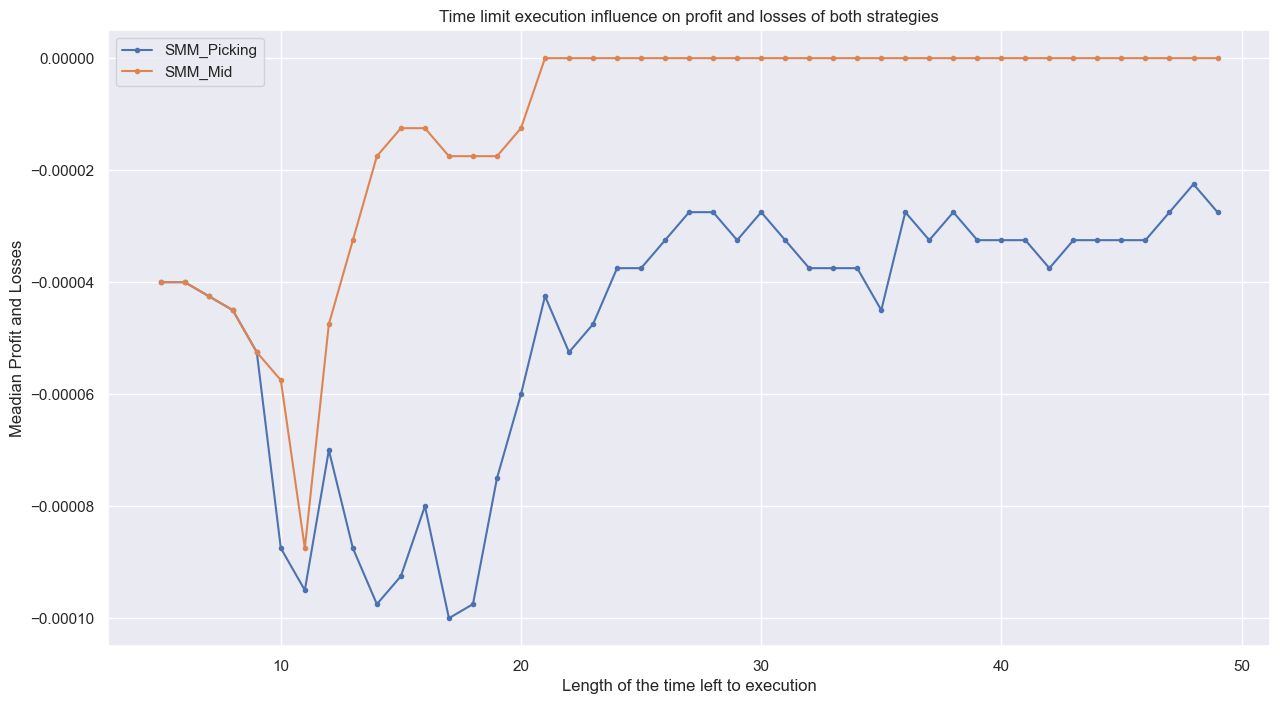

In [27]:
dictionary_tte = {'SMM_Picking':SMM_Picking_median_pnl_tte, 'SMM_Mid':SMM_Mid_median_pnl_tte}
dataframe_tte = pd.DataFrame(data = dictionary_tte, index = range_tte)
tte_pnl = plt.figure(figsize=(15, 8))
ax = tte_pnl.add_subplot(111)
dataframe_tte.plot(y=['SMM_Picking', 'SMM_Mid'], use_index=True,style='.-', ax=ax)
ax.set_xlabel('Length of the time left to execution')
ax.set_ylabel('Meadian Profit and Losses') 
plt.title('Time limit execution influence on profit and losses of both strategies')

* From above plot, it can be seen that the SMM_Mid strategy's profits and losses are higher all the time compared to SMM_Picking strategy.
* As soon as time left to execute reaches 20 for SMM_Mid, the pnl reaches zero level.
* The SMM_Picking strategy was volatile throught the length of time.

### Final Dataframe of the results

In [28]:
execution2 = execution.drop(['TimeStamp','Bid','Ask','Mid','Bid_Ask_Spread'],axis=1)

In [29]:
execution2

,Side,PnL,SMM_Picking_Pnl,SMM_Picking_TE,SMM_Picking_Execution,SMM_Mid_Pnl,SMM_Mid_TE,SMM_Mid_Execution
0,B,-0.000285,-0.000275,49,TTE,-0.000275,49,TTE
1,S,-0.000285,-0.000405,49,TTE,-0.000405,49,TTE
2,B,-0.000285,-0.000275,49,TTE,-0.000275,49,TTE
3,S,-0.000285,-0.000405,49,TTE,-0.000405,49,TTE
4,B,-0.000285,-0.000275,49,TTE,-0.000275,49,TTE
5,B,-0.000285,-0.000275,49,TTE,-0.000275,49,TTE
6,B,-0.000285,-0.000275,49,TTE,-0.000275,49,TTE
7,S,-0.000285,-0.000325,49,TTE,-0.000325,49,TTE
8,S,-0.000285,-0.000325,49,TTE,-0.000325,49,TTE
9,S,-0.000285,-0.000325,49,TTE,-0.000325,49,TTE
